# Bonus Example: Out-of-Sample Share Price Simulation using a Real-World Binomial Lattice
This example will familiarize students with creating real-world binomial lattice simulations of out-of-sample data. We'll use lattice parameters estimated from past data (`2018` to `2023`) to initialize a lattice and simulate future share prices, i.e., from `01-03-24` until `09-23-24`.

### Learning objectives
* __Prerequisites__: we'll begin by loading the dataset. The data we'll explore is daily open-high-low-close values for firms in the [S&P500 index](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2024` until `09-23-2024`. We'll also load the historical lattice parameters.
* __Task 1__: Construct an out-of-sample lattice. In this task, we build a lattice model to simulate data we have not seen before. We used `2018` to `2023` data to estimate the lattice model parameters, but we'll now run price simulations for `2024` data.
* __Task 2__: Compare lattice model prediction versus market observations. In this task, we'll visualize and compare the binomial model simulations with market observations. In particular, we'll compute the expected value and the variance of the simulated price as a function of time and compare with what was observed in the market.

## Setup
We set up the computational environment by including [the `Include.jl` file](Include.jl). The [`Include.jl` file](Include.jl) loads external packages, various functions that we will use in the exercise, and custom types to model the components of our example problem.
* See the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl) for additional information on functions and types used in this material. 

In [3]:
include("Include.jl");

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2024` until yesterday `09-23-24` close, along with data for a few exchange-traded funds and volatility products during that time. We load the `prediction_dataset` by calling the `MyOutOfSampleMarketDataSet()` function:

In [5]:
prediction_dataset = MyOutOfSampleMarketDataSet() |> x-> x["dataset"]

Dict{String, DataFrame} with 488 entries:
  "NI"   => 182×8 DataFrame…
  "EMR"  => 182×8 DataFrame…
  "CTAS" => 182×8 DataFrame…
  "HSIC" => 182×8 DataFrame…
  "KIM"  => 182×8 DataFrame…
  "PLD"  => 182×8 DataFrame…
  "IEX"  => 182×8 DataFrame…
  "BAC"  => 182×8 DataFrame…
  "CBOE" => 182×8 DataFrame…
  "EXR"  => 182×8 DataFrame…
  "NCLH" => 182×8 DataFrame…
  "CVS"  => 182×8 DataFrame…
  "DRI"  => 182×8 DataFrame…
  "DTE"  => 182×8 DataFrame…
  "ZION" => 182×8 DataFrame…
  "AVY"  => 182×8 DataFrame…
  "EW"   => 182×8 DataFrame…
  "EA"   => 182×8 DataFrame…
  "NWSA" => 182×8 DataFrame…
  "BBWI" => 182×8 DataFrame…
  "CAG"  => 182×8 DataFrame…
  "GPC"  => 182×8 DataFrame…
  "FCX"  => 182×8 DataFrame…
  "GILD" => 182×8 DataFrame…
  "UNP"  => 182×8 DataFrame…
  ⋮      => ⋮

Next, let's get a list of firms in the `prediction_dataset,` and save it in the `list_of_all_tickers::String` array

In [7]:
list_of_all_tickers = keys(prediction_dataset) |> collect |> sort;

Finally, we saved the real-world and risk-neutral lattice parameter calculations, so let's load up the saved file to construct our lattice model. To load the `jld2` (binary) saved file, we pass the path to the file we want to load the [`load(...)` function](https://github.com/JuliaIO/FileIO.jl). This call returns the data as a [Julia `Dict` type](https://docs.julialang.org/en/v1/base/collections/#Base.Dict). 
* Let's set the path to the save file in the `path_to_save_file::String` variable.

In [9]:
path_to_save_file = joinpath(_PATH_TO_DATA, "L5a-RealWorldRiskNeutral-SavedData.jld2");

Then we load the `jld2` file using [the `load(...)` method](https://juliaio.github.io/FileIO.jl/stable/reference/#FileIO.load), where the contents of the file are stored in the `saved_data_dictionary::Dict{String, Any}` variable. In particular, we pull out the `real_world_parameters::Dict{String, Tuple{Float64, Float64, Float64}}` dictionary that holds the real-world parameters estimated previously.

In [11]:
saved_data_dictionary = load(path_to_save_file); # saved data as a dictionary
real_world_parameters = saved_data_dictionary["real_world_parameters"]

Dict{String, Tuple{Float64, Float64, Float64}} with 460 entries:
  "NI"   => (1.00888, 0.98974, 0.5428)
  "EMR"  => (1.01135, 0.988176, 0.525547)
  "CTAS" => (1.01068, 0.989279, 0.548772)
  "HSIC" => (1.01165, 0.987478, 0.526211)
  "KIM"  => (1.01443, 0.985488, 0.514267)
  "PLD"  => (1.0109, 0.988852, 0.53351)
  "IEX"  => (1.00984, 0.989644, 0.53351)
  "BAC"  => (1.013, 0.986732, 0.51493)
  "CBOE" => (1.00996, 0.989404, 0.532847)
  "EXR"  => (1.011, 0.989079, 0.522893)
  "NCLH" => (1.0251, 0.975189, 0.500332)
  "CVS"  => (1.01142, 0.988612, 0.506967)
  "DRI"  => (1.01405, 0.986421, 0.514267)
  "DTE"  => (1.0086, 0.990494, 0.53152)
  "ZION" => (1.01719, 0.98292, 0.504977)
  "AVY"  => (1.01164, 0.987978, 0.529529)
  "EW"   => (1.01274, 0.986972, 0.530192)
  "EA"   => (1.01135, 0.988119, 0.523557)
  "NWSA" => (1.01291, 0.987378, 0.511612)
  "CAG"  => (1.01029, 0.989518, 0.502322)
  "GILD" => (1.01021, 0.989964, 0.50365)
  "FCX"  => (1.02229, 0.979183, 0.504977)
  "GPC"  => (1.01038, 0.989

Finally, let's set some constants we'll use later in this notebook. The comments describe the constants, the units, permissible values, etc.

In [13]:
Δt = (1.0/252); # step size: 1-trading day in units of years
risk_free_rate = 0.0; # hypothetical continuously compounding risk-free rate

## Task 1: Construct an out-of-sample lattice
In this task, we build a lattice model to simulate data we have not seen before. We used `2018` to `2023` data to estimate the lattice model parameters, but we'll now run price simulations for `2024` data.

For the out-of-sample simulation, let's begin by specifying a `my_ticker_of_interest::String` and a `start_index::Int64` value. Note that when specifying the ticker to simulate, we need to select a value present in the lattice model parameters dictionary. We'll do a quick check to verify before we continue. 

In [15]:
my_ticker_of_interest = "IBM";
@assert my_ticker_of_interest ∈ (keys(real_world_parameters) |> collect) # this checks that we have data for my_ticker_of_interest

Next, specify a start index and the length of the simulation (specified in the `L::Int64` variable):

In [17]:
start_index = 1; # start the first trading day of the year
L = 182; # number of trading days that we want to simulate

Now, let's construct an instance of [the `MyBinomialEquityPriceTree` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyBinomialEquityPriceTree) using the estimated values for `(u,d,p).` This enables us to calculate the prices and probabilities in the tree. We store the populated model in the variable `random_test_model` for future use. First, get the estimated values for the lattice parameters from the `real_world_parameters::Dict{String, Tuple{Float64, Float64, Float64}}` dictionary

In [19]:
û = real_world_parameters[my_ticker_of_interest][1];   # average up-factor the \hat denotes estimate
d̂ = real_world_parameters[my_ticker_of_interest][2];   # average down factor the \hat denotes estimate
p̂ = real_world_parameters[my_ticker_of_interest][3];   # probability of an up-move the \hat denotes estimate

Next, we get the initial value of the share price from the data and save it to the `Sₒ::Float64` variable. This will be the price at the root of the tree:

In [21]:
Sₒ = prediction_dataset[my_ticker_of_interest][start_index,:volume_weighted_average_price];

Finally, we build and populate [the `MyBinomialEquityPriceTree` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyBinomialEquityPriceTree) using the [`build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyBinomialEquityPriceTree},%20NamedTuple}) which builds an empty tree skeleton, and [the `populate(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.populate-Tuple{MyBinomialEquityPriceTree}) which fills in the values of the tree:

In [23]:
random_test_model = build(MyBinomialEquityPriceTree, (
    u = û, d = d̂, p = p̂)) |> (model -> populate(model, Sₒ = Sₒ, h = L));

### Visualize price distribution at tree level `L`
`Unide` the code block below to see how we plotted the predicted price distribution for `my_ticker_of_interest` at tree level `L`. 

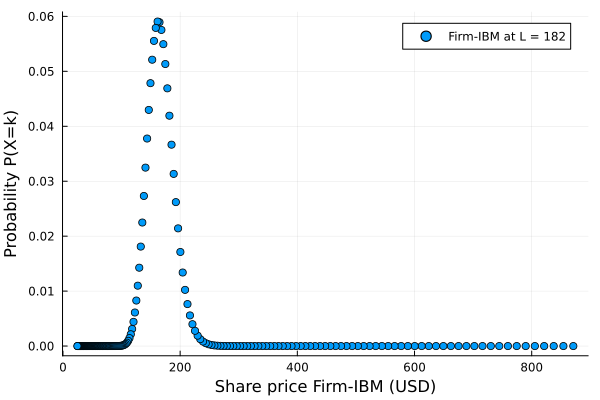

In [25]:
let
    price_array = random_test_model.levels[L] .|> x-> random_test_model.data[x].price
    probability_array = random_test_model.levels[L] .|> x-> random_test_model.data[x].probability;
    scatter(price_array, probability_array, label="Firm-$(my_ticker_of_interest) at L = $(L)")
    xlabel!("Share price Firm-$(my_ticker_of_interest ) (USD)", fontsize=18)
    ylabel!("Probability P(X=k)", fontsize=18)
end

## Task 2: Compare lattice model prediction versus market observations
In this task, we'll visualize and compare the binomial model simulations with market observations. In particular, we'll compute the expected value and the variance of the simulated price as a function of time, i.e., at each level in the tree using the local [`𝔼(...)`](src/Compute.jl) and [`Var(...)` functions](src/Compute.jl).
* The `levels` array holds the index of the tree levels, i.e., the time slices. The [`𝔼(...)`](src/Compute.jl) and [`Var(...)` functions](src/Compute.jl) take the `random_test_model` tree model, and the `levels` array and return the expectation and the variance, respectively. 

In [27]:
levels = [k for k ∈ 0:(L - 1)]
expectation = 𝔼(random_test_model, levels); # compute the expected value
variance = Var(random_test_model, levels); # compute the variance

`Unhide` the code block below to see how we plotted the model simulations and the observed prices for a randomly selected firm using a binomial lattice model.
* __Summary__: Depending upon the ticker, the observed price (red line) may or may not lie in the $\pm\,{z}\cdot\sigma$ confidence ranges, where `z = {1,1.96,2.576}` which are shown in progressively lighter shades of blue. The dashed dark blue line shows the expected value.

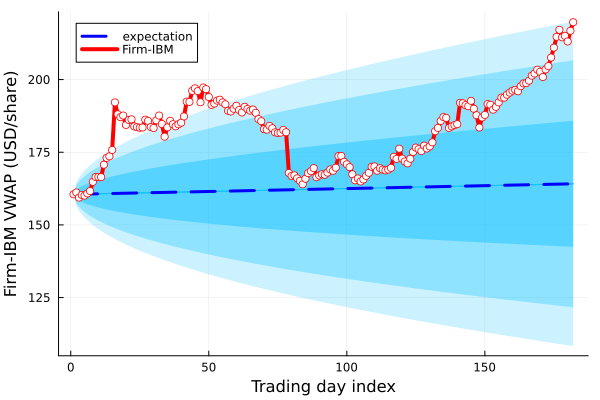

In [29]:
let 
    
    random_firm_data = prediction_dataset[my_ticker_of_interest];
    
    L68 = expectation[:,2] .- sqrt.(variance[:,2])
    U68 = expectation[:,2] .+ sqrt.(variance[:,2])
    L95 = expectation[:,2] .- 1.96*sqrt.(variance[:,2])
    U95 = expectation[:,2] .+ 1.96*sqrt.(variance[:,2])
    L99 = expectation[:,2] .- 2.576*sqrt.(variance[:,2])
    U99 = expectation[:,2] .+ 2.576*sqrt.(variance[:,2])

    T_sim = range(start_index, stop=L, step=1) |> collect 
    plot(T_sim, expectation[:,2], fillrange=L68, c=:deepskyblue1, alpha=0.4, label="")
    plot!(T_sim, expectation[:,2], fillrange=U68, c=:deepskyblue1, alpha=0.4, label="")
    plot!(T_sim, expectation[:,2], fillrange=L95, c=:deepskyblue1, alpha=0.3, label="")
    plot!(T_sim, expectation[:,2], fillrange=U95, c=:deepskyblue1, alpha=0.3, label="")
    plot!(T_sim, expectation[:,2], fillrange=L99, c=:deepskyblue1, alpha=0.2, label="")
    plot!(T_sim, expectation[:,2], fillrange=U99, c=:deepskyblue1, alpha=0.2, label="")
    plot!(T_sim, expectation[:,2],c=:blue, lw=3,ls=:dash, label="expectation")
    plot!(T_sim, random_firm_data[levels .+ start_index, :volume_weighted_average_price],  
         lw=4, c=:red, label="Firm-$(my_ticker_of_interest)", legend = :topleft)
    scatter!(T_sim, random_firm_data[levels .+ start_index, :volume_weighted_average_price], label="", 
         msc=:red, mc=:white)

    xlabel!("Trading day index", fontsize=18)
    ylabel!("Firm-$(my_ticker_of_interest) VWAP (USD/share)", fontsize=18)
end

### Check: Was this a `successful` simulation?
Determining if a model accurately represents data can be done in various ways, but we will utilize a simple, straightforward, functional test. This test involves checking if the simulated price falls within a specified lower bound ($L_{j}$) and upper bound ($U_{j}$) for all times $t_j$ within a given interval ($t_{j}\in\mathcal{I}_{k}$). 
* __Success__: If the simulation meets this requirement, it is deemed a `success.` The values for $L_{j}$ and $U_{j}$ can be customized, but we set these to $\mathbb{E}(X)\pm{2.576}\cdot{\sigma}$, where $\mathbb{E}(X)$ represents the expected value and $\sigma$ is the standard deviation of the binomial lattice model simulation. 
* __Failure__: However, if the actual price exceeds the given bounds at any point, the simulation is considered a `failure.`

In [31]:
let
    z = 2.576
    LB = expectation[:,2] .- z*sqrt.(variance[:,2])
    UB = expectation[:,2] .+ z*sqrt.(variance[:,2])
    random_firm_data = prediction_dataset[my_ticker_of_interest];
    stop_index = start_index + L
    
    # check the bounds: if below LB, or above UB then the simulation failed
    success_flag = true;
    for k ∈ 1:L
        
        price_value = random_firm_data[start_index+k-1,:volume_weighted_average_price];    
        if (price_value < LB[k]) || (price_value > UB[k])            
            success_flag = false;
            break;
        end
    end

    println("The simulation of the VWAP of Firm-$(my_ticker_of_interest) between ($(start_index) -> $(stop_index)) was successful: $(success_flag)")
end

The simulation of the VWAP of Firm-IBM between (1 -> 183) was successful: false


## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.